# Mapping Twitter Data
This notebook provides the basis for developing spatial representations of a variety of interesting data that is presented in the Ferguson Twitter dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import json
import time
import pandas as pd
import cartopy.crs as ccrs
from ipywidgets import widgets
import matplotlib.cm as cm

/Users/Sophia/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Let's begin with the data. We have two datasets. The first is data from the two weeks following the initial shooting. The second is data from the two weeks following the indictment. Twitter has provided an extensive amount of data for us, and we have developed a cleaning mechanism which can be observed in a seperate script. The data is placed in a data frame:

In [2]:
def ReadAndAggregate(linesAtATime,filepath, aggregationFunction):
    i = 0
    data = [] 
    
    #Open and read in the file
    with open(filename) as cleanedTweets:
        for tweet in cleanedTweets:
            i += 1
            jsonline = json.loads(tweet)
            data.append(jsonline)
            #aggregate once we've read in the appropriate number of liens
            if (i % linesAtATime == 0):
                print i
                df = pd.DataFrame(data=data)
                #First time running through
                if (i == linesAtATime):
                    agg = aggregationFunction(df)
                else:
                    agg = aggregationFunction(df, agg)
                #reset the data
                data = []
        #Handle the last few tweets
        df = pd.DataFrame(data=data)
        agg = aggregationFunction(df, agg)
    #return the aggregation
    return agg

In [3]:
def createHashtagsDf (df, hashtagsDataFrame=pd.DataFrame()):
    
    #time based recodes
    df['DoW'] = df['created_at'].apply(lambda x: str(x)[0:3:])
    df['Month'] = df['created_at'].apply(lambda x: str(x)[4:7:])
    df['DoM'] = df['created_at'].apply(lambda x: str(x)[8:10:])
    df['Hour'] = df['created_at'].apply(lambda x: int(str(x)[11:13:]))
    df['Minute'] = df['created_at'].apply(lambda x: int(str(x)[14:16:]))

    #let's grab the coordinates from the coordinates field, which is actually a dictionary
    coords = []
    for i in range(len(df)):
        location = df['coordinates'][i]
        try: #want to make sure that null values don't throw an exception
            coords.append(location.get('coordinates'))
        except:
            coords.append([None,None])

    df['Coords'] = coords
    df['x'] = df['Coords'].apply(lambda x: x[0])
    df['y'] = df['Coords'].apply(lambda x: x[1])

    #now, let's grab the information from place, which is similarly a very detailed dictionary of elements
    name = []
    country = []
    coordinates = []
    full_name = []
    for i in range(len(df)):
        location = df['place'][i]
        try:
            coordinates.append(location.get('bounding_box').get('coordinates'))
            name.append(location.get('name'))
            full_name.append(location.get('full_name'))
            country.append(location.get('country'))
        except:
            coordinates.append([[[0,0],[0,0],[0,0],[0,0]]])
            name.append('')
            full_name.append('')
            country.append('')

    mean_coords = []
    for box in coordinates:
        mean_coord_x = (box[0][0][0]+box[0][1][0]+box[0][2][0]+box[0][3][0])/4
        mean_coord_y = (box[0][0][1]+box[0][1][1]+box[0][2][1]+box[0][3][1])/4
        mean_coords.append([mean_coord_x,mean_coord_y])

#     df['city'] = name
#     df['country'] = country
#     df['full_name'] = full_name
    df['P_Coords'] = mean_coords
    df['x_p'] = df['P_Coords'].apply(lambda x: x[0])
    df['y_p'] = df['P_Coords'].apply(lambda x: x[1])
    
    rowsToAdd = []
    for index,tweet in df.iterrows():
        for hashtag in tweet['entities_hashtags_text']:
            rowsToAdd.append({
                    'DoW': tweet['DoW'],
                    'Month': tweet['Month'],
                    'DoM': tweet['DoM'],
                    'Hour': tweet['Hour'],
                    'Minute': tweet['Minute'],
                    'Hashtag': hashtag.upper(),
                    'x': tweet['x'],
                    'y': tweet['y'],
                    'x_p': tweet['x_p'],
                    'y_p': tweet['y_p'],
                    'tweetId': tweet['id_str']
                })
    tempDf = pd.DataFrame(rowsToAdd)
    hashtagsDataFrame = hashtagsDataFrame.append(tempDf)

    return hashtagsDataFrame

In [4]:
filename='./data/cleanedShootingTweets.json'
data = ReadAndAggregate(100000,filename, createHashtagsDf)


100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000


In [5]:
data['x'].fillna(value = data['x_p'], inplace = True)
data['y'].fillna(value = data['y_p'], inplace = True)

In [6]:
data

,DoM,DoW,Hashtag,Hour,Minute,Month,tweetId,x,x_p,y,y_p
0,17,Sun,FERGUSON,17,52,Aug,501064141332029440,0,0,0,0
1,17,Sun,FERGUSON,17,53,Aug,501064171707170816,0,0,0,0
2,17,Sun,FERGUSON,17,53,Aug,501064180468682752,0,0,0,0
3,17,Sun,USNEWS,17,53,Aug,501064194309906436,0,0,0,0
4,17,Sun,FERGUSON,17,53,Aug,501064196642340864,0,0,0,0
5,17,Sun,FERGUSON,17,53,Aug,501064196931330049,0,0,0,0
6,17,Sun,MIKEBROWN,17,53,Aug,501064196931330049,0,0,0,0
7,17,Sun,FERGUSON,17,53,Aug,501064197632167936,0,0,0,0
8,17,Sun,TCOT,17,53,Aug,501064197632167936,0,0,0,0
9,17,Sun,UNITEBLUE,17,53,Aug,501064197632167936,0,0,0,0


In [7]:
data['x']

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
58829    0
58830    0
58831    0
58832    0
58833    0
58834    0
58835    0
58836    0
58837    0
58838    0
58839    0
58840    0
58841    0
58842    0
58843    0
58844    0
58845    0
58846    0
58847    0
58848    0
58849    0
58850    0
58851    0
58852    0
58853    0
58854    0
58855    0
58856    0
58857    0
58858    0
Name: x, dtype: float64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4159744 entries, 0 to 58858
Data columns (total 11 columns):
DoM        object
DoW        object
Hashtag    object
Hour       int64
Minute     int64
Month      object
tweetId    object
x          float64
x_p        float64
y          float64
y_p        float64
dtypes: float64(4), int64(2), object(5)
memory usage: 380.8+ MB


/Users/Sophia/anaconda/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


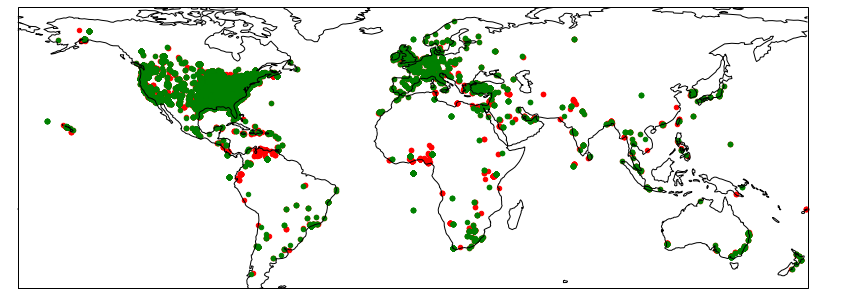

In [9]:
#the cartopy map, going simple outline for now
plt.figure(figsize=(15,15))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

#straight-up coordinate data which we just finished recoding
plt.scatter(data.x,data.y,color='r')
plt.scatter(data.x_p,data.y_p,color='g')

plt.show()

Now, to add a temporal element to this, we add a slider which pulls in some of the time columns we also just pulled out of interest.

In [10]:
latLonPopulated = data[(data['x'] != 0) & (data['y'] != 0)]

In [11]:
latLonPopulated

,DoM,DoW,Hashtag,Hour,Minute,Month,tweetId,x,x_p,y,y_p
420,17,Sun,RACISM,17,53,Aug,501064361788862465,-80.670740,-80.649699,28.139480,28.117874
421,17,Sun,SMH,17,53,Aug,501064361788862465,-80.670740,-80.649699,28.139480,28.117874
422,17,Sun,LUKEBRYAN,17,53,Aug,501064361788862465,-80.670740,-80.649699,28.139480,28.117874
423,17,Sun,FERGUSON,17,53,Aug,501064361788862465,-80.670740,-80.649699,28.139480,28.117874
559,17,Sun,FERGUSON,17,53,Aug,501064409679421440,9.003542,9.003542,48.661709,48.661709
714,17,Sun,FERGUSON,17,54,Aug,501064473965510656,-122.251715,-122.330602,47.672935,47.614817
991,17,Sun,FERGUSON,17,54,Aug,501064579946790912,-94.484954,-94.498228,37.048930,37.096519
1252,17,Sun,BALTIMORE,17,55,Aug,501064692165783553,-76.620482,-76.620482,39.284713,39.284713
1253,17,Sun,FERGUSON,17,55,Aug,501064692165783553,-76.620482,-76.620482,39.284713,39.284713
1447,17,Sun,SADTRAILS,17,55,Aug,501064755596242944,-124.414311,-124.415765,43.109538,43.111422


In [12]:
hashtagGrouped = latLonPopulated.groupby('Hashtag').count().reset_index().sort_values(by = 'DoM', ascending = False)
sortedHashtags = hashtagGrouped['Hashtag'].tolist()
topHashtags = sortedHashtags[0:10]

In [13]:
topHashtags

[u'FERGUSON',
 u'MIKEBROWN',
 u'MICHAELBROWN',
 u'FERGUSONSHOOTING',
 u'JUSTICEFORMIKEBROWN',
 u'CNN',
 u'HANDSUPDONTSHOOT',
 u'TCOT',
 u'GAZA',
 u'STL']

In [16]:
def plotHashtagLocation(DoM, Hour):
    plt.figure(figsize=(15,15))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    
    for i,hashtag in enumerate(topHashtags):
        subset = latLonPopulated[
            (latLonPopulated['DoM'] == str(DoM)) & 
            (latLonPopulated['Hour']==Hour) & 
            (latLonPopulated['Hashtag'] == hashtag)]
        if (len(subset) == 0):
            continue
        
        plt.scatter(subset.x,subset.y, color= cm.jet(i/float(len(topHashtags))), label = hashtag)
#         plt.scatter(subset.x_p,subset.y_p, color= cm.jet(i/float(len(topHashtags))), label = hashtag)
#     plt.axis([-180, 180, -75, 75])
    plt.axis([-180, 0, -75, 75])
    plt.legend()

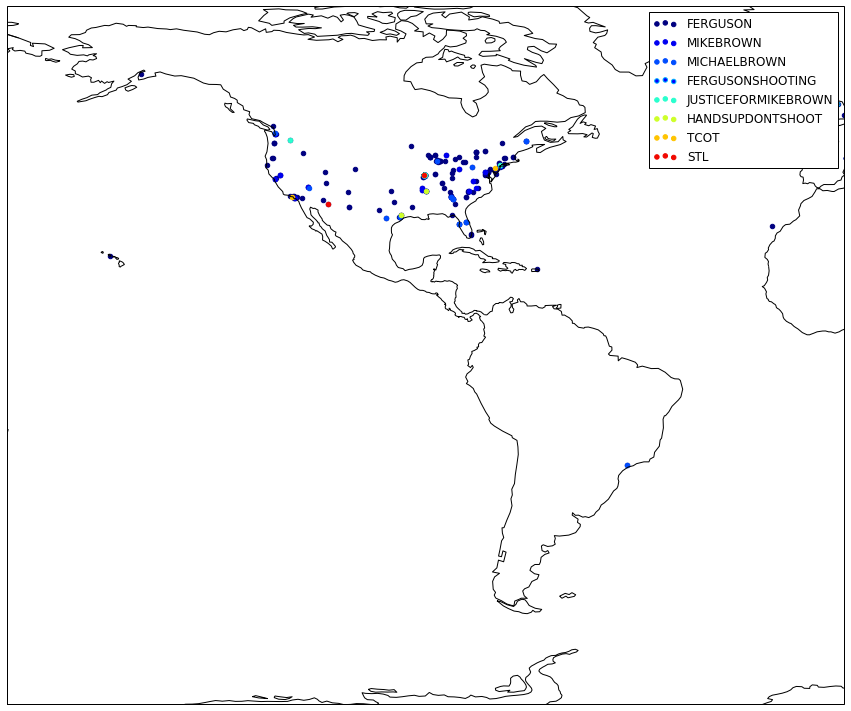

In [17]:
DoM = widgets.IntSlider(min=10, max=27, value=17)
Hour = widgets.IntSlider(min=0, max=23, value=17)
widgets.interact(plotHashtagLocation,DoM = DoM, Hour=Hour)